In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [7]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

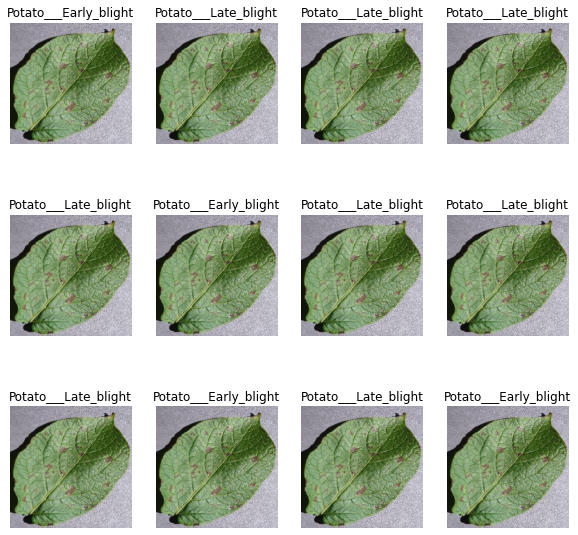

In [11]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [15]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)


8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds =  ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
data_agumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_agumentation,
    layers.Conv2D(32,(3,3), activation='relu',input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax'),
    
    
])
model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [25]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 140s 2s/step - loss: 0.9072 - accuracy: 0.4878 - val_loss: 0.8943 - val_accuracy: 0.4375
Epoch 2/50
54/54 [==============================] - 120s 2s/step - loss: 0.6671 - accuracy: 0.6811 - val_loss: 0.5494 - val_accuracy: 0.7708
Epoch 3/50
54/54 [==============================] - 101s 2s/step - loss: 0.3196 - accuracy: 0.8796 - val_loss: 0.2314 - val_accuracy: 0.9115
Epoch 4/50
54/54 [==============================] - 97s 2s/step - loss: 0.2263 - accuracy: 0.9109 - val_loss: 0.1392 - val_accuracy: 0.9531
Epoch 5/50
54/54 [==============================] - 110s 2s/step - loss: 0.1883 - accuracy: 0.9317 - val_loss: 0.2449 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 97s 2s/step - loss: 0.0989 - accuracy: 0.9659 - val_loss: 0.2700 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 96s 2s/step - loss: 0.1001 - accuracy: 0.9595 - val_loss: 0.1762 - val_accuracy: 0.9531
Epoch 8/50
54/54

In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 14s 425ms/step - loss: 0.0522 - accuracy: 0.9766


In [47]:
history

In [48]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [49]:
history.history['accuracy']

[0.4878472089767456,
 0.6811342835426331,
 0.8796296119689941,
 0.9108796119689941,
 0.9317129850387573,
 0.9658564925193787,
 0.9594907164573669,
 0.9641203880310059,
 0.9681712985038757,
 0.9670138955116272,
 0.9699074029922485,
 0.9785879850387573,
 0.9675925970077515,
 0.9780092835426331,
 0.9809027910232544,
 0.9832175970077515,
 0.9861111044883728,
 0.9837962985038757,
 0.9832175970077515,
 0.9826388955116272,
 0.9797453880310059,
 0.9774305820465088,
 0.9785879850387573,
 0.9861111044883728,
 0.9890046119689941,
 0.984375,
 0.9855324029922485,
 0.9814814925193787,
 0.9832175970077515,
 0.9913194179534912,
 0.9890046119689941,
 0.9890046119689941,
 0.9901620149612427,
 0.9791666865348816,
 0.9791666865348816,
 0.9907407164573669,
 0.9930555820465088,
 0.9907407164573669,
 0.9936342835426331,
 0.9878472089767456,
 0.9884259104728699,
 0.9942129850387573,
 0.9884259104728699,
 0.9976851940155029,
 0.9930555820465088,
 0.9832175970077515,
 0.9837962985038757,
 0.9878472089767456,
 0

In [50]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


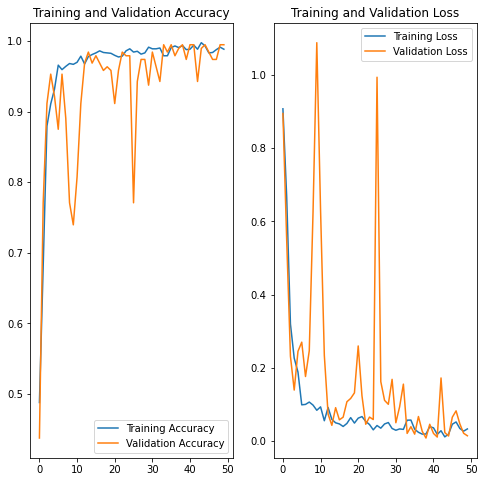

In [52]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
predicted label Potato___Early_blight


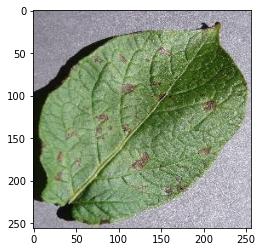

In [53]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted label",class_names[np.argmax(batch_prediction[0])])

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

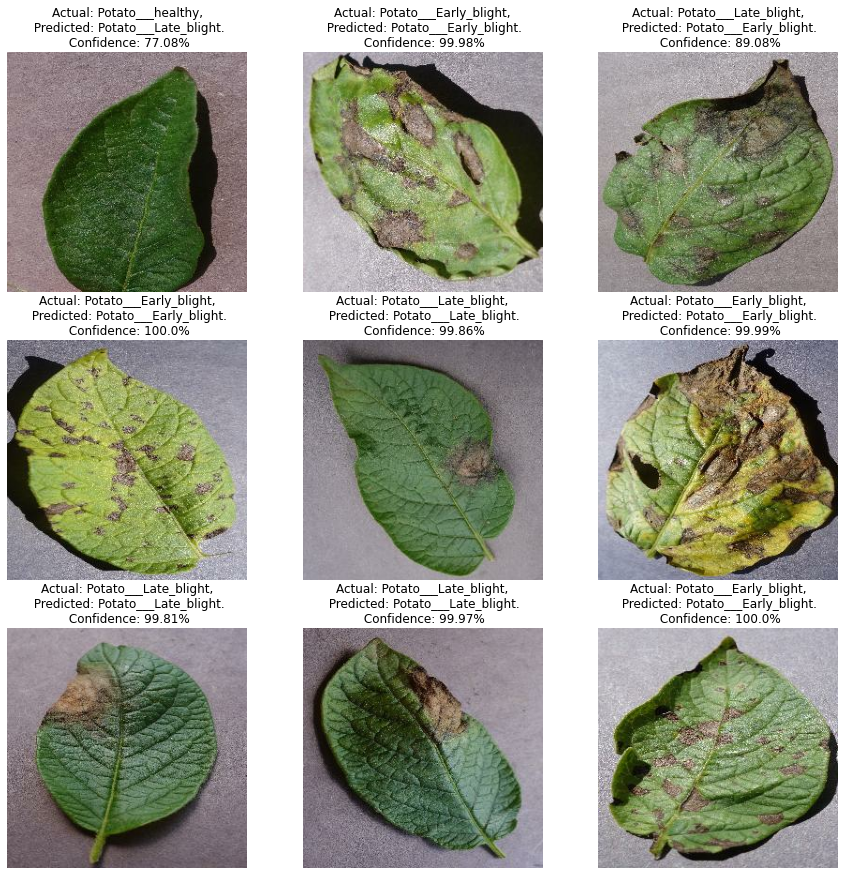

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [56]:
# import os
# model_version=max([int(i) for i in os.listdir("D:\python dev\potato disease project\models") + [0]])+1
# model.save(f"D:\python dev\potato disease project\models{model_version}")
import os
destination_dir = r"D:\python dev\potato disease project\models"
os.makedirs(destination_dir, exist_ok=True)


In [57]:
model.save(os.path.join(destination_dir, 'my_model.h5'))

In [61]:

def save_model(model_version):
    model = keras.models.Sequential()
    # Add your model layers here

    model.save(f"D:/python dev/potato disease project/models/{model_version}")

model_version = 1
save_model(model_version)

<IPython.core.display.Javascript object>

ValueError: Model <keras.engine.sequential.Sequential object at 0x000001E216A92100> cannot be saved because the input shapes have not been set. Usually, input shapes are automatically determined when calling `.fit()` or `.predict()`. To manually set the shapes, call `model.build(input_shape)